In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from tensorflow.keras.applications import Xception, DenseNet121
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tkinter import *
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import seaborn as sns

import os

In [2]:
print(os.listdir('C:/Users/ahmed/Documents/dlProject/mydataset/'))
print(os.listdir('C:/Users/ahmed/Documents/dlProject/mydataset/Training'))
print(os.listdir('C:/Users/ahmed/Documents/dlProject/mydataset/Testing'))


['Testing', 'Training']
['cardboard', 'glass', 'metals', 'plastic', 'wood']
['cardboard', 'glass', 'metals', 'plastic', 'wood']


In [3]:
train_folders = glob.glob("C:/Users/ahmed/Documents/dlProject/mydataset/Training/*")
test_folders = glob.glob("C:/Users/ahmed/Documents/dlProject/mydataset/Testing/*")

print("Training Folders Found:", train_folders)
print("Testing Folders Found:", test_folders)


Training Folders Found: ['C:/Users/ahmed/Documents/dlProject/mydataset/Training\\cardboard', 'C:/Users/ahmed/Documents/dlProject/mydataset/Training\\glass', 'C:/Users/ahmed/Documents/dlProject/mydataset/Training\\metals', 'C:/Users/ahmed/Documents/dlProject/mydataset/Training\\plastic', 'C:/Users/ahmed/Documents/dlProject/mydataset/Training\\wood']
Testing Folders Found: ['C:/Users/ahmed/Documents/dlProject/mydataset/Testing\\cardboard', 'C:/Users/ahmed/Documents/dlProject/mydataset/Testing\\glass', 'C:/Users/ahmed/Documents/dlProject/mydataset/Testing\\metals', 'C:/Users/ahmed/Documents/dlProject/mydataset/Testing\\plastic', 'C:/Users/ahmed/Documents/dlProject/mydataset/Testing\\wood']



Preprocessing

In [4]:
data_dir = "C:/Users/ahmed/Documents/dlProject/mydataset"
size = 256

# Load training data
train_images, train_labels = [], []
class_counter = {}
for directory_path in glob.glob("C:/Users/ahmed/Documents/dlProject/mydataset/Training/*"):
    label = os.path.basename(directory_path)
    class_counter[label] = 0
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if class_counter[label] >= 800:
            break
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) #Reads the image as a color image (3 channels: RGB)
        img = cv2.resize(img, (size, size)) 
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #Converts the image color format from OpenCV's default (BGR) to RGB
        train_images.append(img)
        train_labels.append(label)
        class_counter[label] += 1

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Load testing data
test_images, test_labels = [], []
for directory_path in glob.glob("C:/Users/ahmed/Documents/dlProject/mydataset/Testing/*"):
    label = os.path.basename(directory_path)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size, size))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label)

# Convert the list to numpy arrays after the loop
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Check shapes
print(f"Test Images: {test_images.shape}")
print(f"Test Labels: {len(test_labels)}")

# lables ['cardboard', 'glass', 'metals', 'plastic', 'wood'] example bas law test hayb2a 200 le kol class



Test Images: (1000, 256, 256, 3)
Test Labels: 1000


In [46]:
print(f"Test Labels: {train_labels_encoded}")

Test Labels: [0 0 0 ... 4 4 4]


In [5]:
#converting class labels into numerical values 
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
test_labels_encoded = le.transform(test_labels)


Normalization

In [6]:
# Prepare data for training scales the pixel values to a range of [0, 1] 
# reduces the risk of vanishing/exploding gradients, and speeds up training
# One-hot encoding enables the model to compute loss functions 
x_train, y_train = train_images / 255.0, to_categorical(train_labels_encoded)
x_test, y_test = test_images / 255.0, to_categorical(test_labels_encoded)

**ResNet** **Model**

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
# Define a Basic Block
def basic_block(x, filters, stride=1):
    """
    Implements the basic block for ResNet
    """
    # Save the input for the skip connection
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    # Skip connection
    if stride != 1 or tf.keras.backend.int_shape(shortcut)[-1] != filters:
        # Adjust shortcut to match the new dimension
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Define a ResNet Layer (stack of basic blocks)
def resnet_layer(x, filters, blocks, stride=1):
    """
    Creates a ResNet layer made of `blocks` basic blocks
    """
    x = basic_block(x, filters, stride)
    for _ in range(1, blocks):
        x = basic_block(x, filters, stride=1)
    return x

# Define the ResNet model
def build_resnet(input_shape, num_classes):
    """
    Builds the ResNet model
    """
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # ResNet Layers
    x = resnet_layer(x, filters=64, blocks=3, stride=1)  # Layer 1
    x = resnet_layer(x, filters=128, blocks=4, stride=2) # Layer 2
    x = resnet_layer(x, filters=256, blocks=6, stride=2) # Layer 3
    x = resnet_layer(x, filters=512, blocks=3, stride=2) # Layer 4
    
    # Global Average Pooling and Dense Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs, outputs)
    return model

# Build and compile the ResNet model
num_classes = len(le.classes_)  # Number of output classes
input_shape = (size, size, 3)   # Image size
resnet_model = build_resnet(input_shape, num_classes)

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     36,864 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,864 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,864 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 21,304,261 (81.27 MB)

 Trainable params: 21,287,237 (81.20 MB)

 Non-trainable params: 17,024 (66.50 KB)

Train Resnet

In [8]:
from tensorflow.keras.callbacks import LambdaCallback

# 3shan nshof el acc fel run 
print_accuracy = LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1} - Training Accuracy: {logs['accuracy']:.4f}, Validation Accuracy: {logs['val_accuracy']:.4f}"))

history = resnet_model.fit(
    x_train, 
    y_train, 
    validation_data=(x_test, y_test), 
    epochs=15, 
    batch_size=32,
    callbacks=[print_accuracy] 
)

#7eta save keda
resnet_model.save('resnet_model_from_scratch.keras')

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4578 - loss: 1.8930Epoch 1 - Training Accuracy: 0.5130, Validation Accuracy: 0.2270
125/125 ━━━━━━━━━━━━━━━━━━━━ 863s 7s/step - accuracy: 0.4582 - loss: 1.8889 - val_accuracy: 0.2270 - val_loss: 2.5233
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5834 - loss: 1.0826Epoch 2 - Training Accuracy: 0.6102, Validation Accuracy: 0.3340
125/125 ━━━━━━━━━━━━━━━━━━━━ 841s 7s/step - accuracy: 0.5836 - loss: 1.0822 - val_accuracy: 0.3340 - val_loss: 2.2347
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6161 - loss: 1.0016Epoch 3 - Training Accuracy: 0.6248, Validation Accuracy: 0.2950
125/125 ━━━━━━━━━━━━━━━━━━━━ 802s 6s/step - accuracy: 0.6161 - loss: 1.0015 - val_accuracy: 0.2950 - val_loss: 2.6482
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6133 - loss: 0.9686Epoch 4 - Training Accuracy: 0.6350, Validation Accuracy: 0.5520
125/125 ━━━━━━━━━━━━━━━━━━━━ 805s 6s/step - accura

# Evaluate ResNet Model

32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step


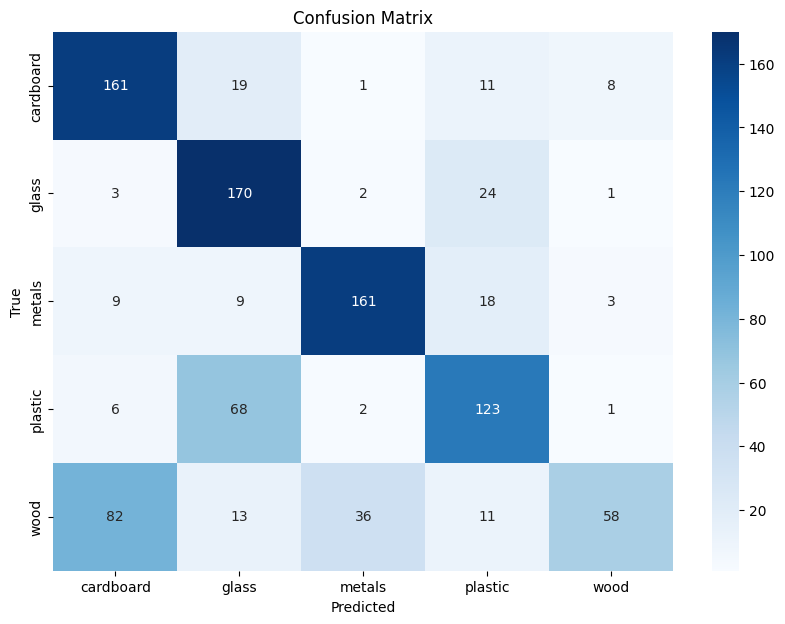

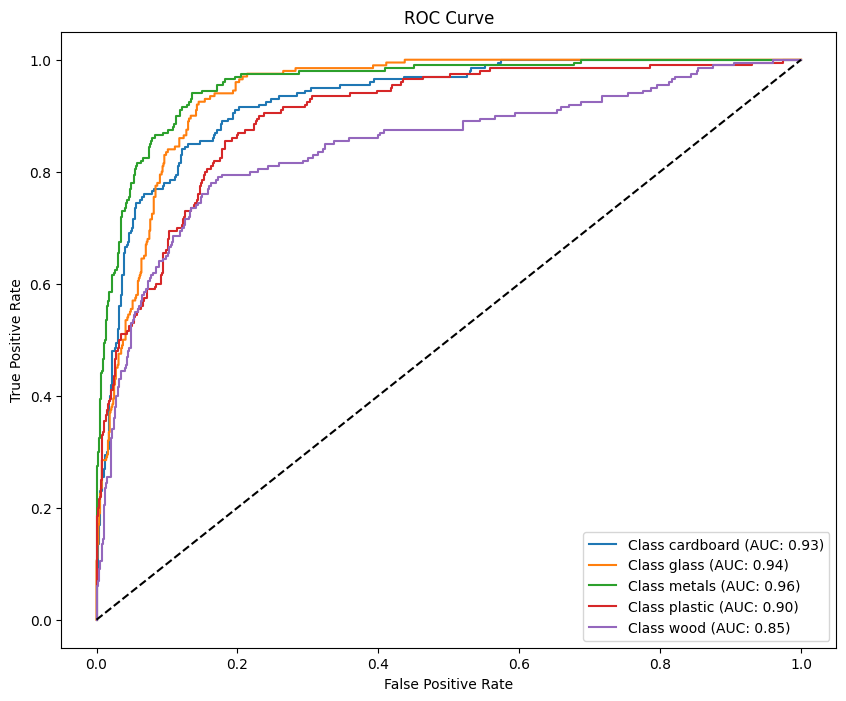

Accuracy: 0.6730
Precision: 0.6996
Recall: 0.6730
F1 Score: 0.6546
AUC Scores: [np.float64(0.92854375), np.float64(0.9408093750000001), np.float64(0.95695), np.float64(0.9006937499999998), np.float64(0.8450312500000001)]


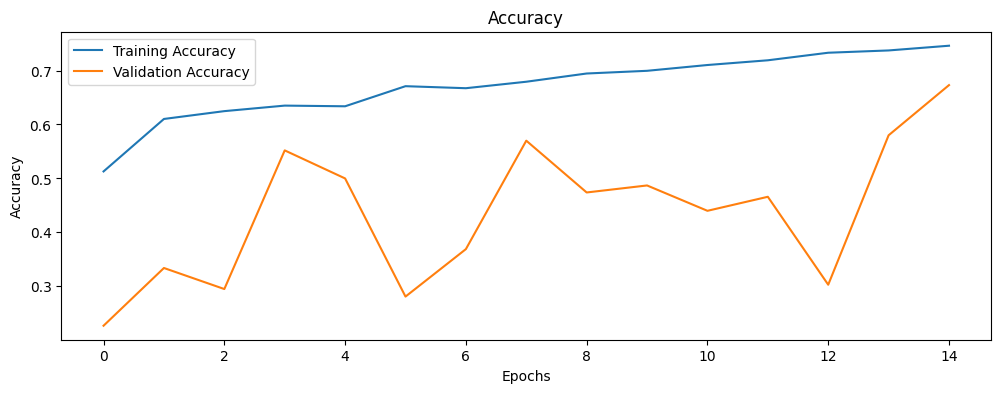

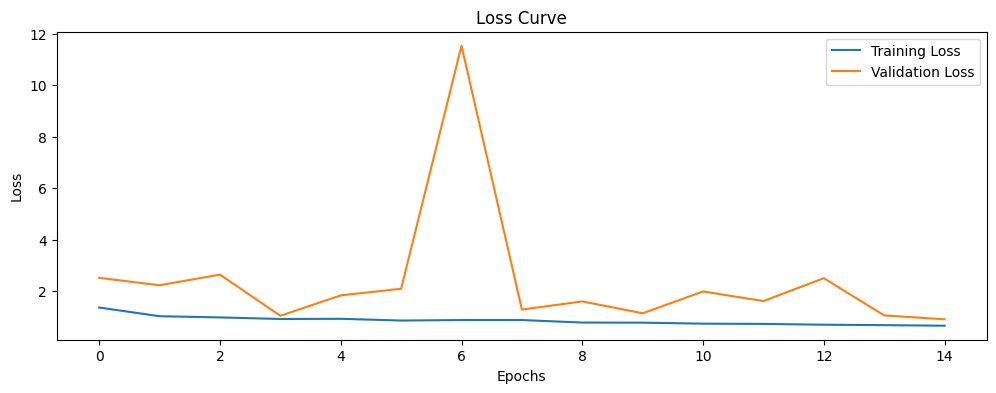

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize


def evaluate_model(model, x_test, y_test, le):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Accuracy, Precision, Recall, F1 Score
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average="weighted")
    recall = recall_score(y_true_classes, y_pred_classes, average="weighted")
    f1 = f1_score(y_true_classes, y_pred_classes, average="weighted")

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve and AUC
    y_test_binarized = label_binarize(y_true_classes, classes=np.arange(len(le.classes_)))
    auc_scores = []

    plt.figure(figsize=(10, 8))
    for i in range(len(le.classes_)):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        plt.plot(fpr, tpr, label=f"Class {le.classes_[i]} (AUC: {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    return accuracy, precision, recall, f1, auc_scores

# Plot Accuracy
def plot_accuracy(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot Loss Curve
def plot_loss(history):
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Final evaluation for ResNet Model
accuracy, precision, recall, f1, auc_scores = evaluate_model(resnet_model, x_test, y_test, le)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Scores: {auc_scores}")

# Plot accuracy and loss curves
plot_accuracy(history)
plot_loss(history)


**PreTrained Models Function**

In [10]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

def transfer_learning_xception_model(base_model):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
    x = Dense(1024, activation='relu')(x)
    output_layer = Dense(len(le.classes_), activation="softmax")(x)  # Softmax output layer
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

**Evaluation** **Function**

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
import torch
import numpy as np

# Function to evaluate models
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Accuracy, Precision, Recall, F1 Score
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average="weighted")
    recall = recall_score(y_true_classes, y_pred_classes, average="weighted")
    f1 = f1_score(y_true_classes, y_pred_classes, average="weighted")

    # Confusion Matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Curve and AUC
    y_test_binarized = label_binarize(y_true_classes, classes=np.arange(len(le.classes_)))
    auc_scores = []

    for i in range(len(le.classes_)):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        auc_score = auc(fpr, tpr)
        auc_scores.append(auc_score)
        plt.plot(fpr, tpr, label=f"Class {le.classes_[i]} (AUC: {auc_score:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    return accuracy, precision, recall, f1

**Xception**

In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout

def transfer_learning_xception_model(base_model):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
    x = Dense(1024, activation='relu')(x)
    output_layer = Dense(len(le.classes_), activation="softmax")(x)  # Softmax output layer
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall", "AUC"])
    return model

In [13]:
xception_model = transfer_learning_xception_model(Xception(weights="imagenet", include_top=False, input_shape=(size, size, 3)))

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [15]:
xception_history = xception_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, callbacks=[early_stopping])


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - AUC: 0.9272 - Precision: 0.7753 - Recall: 0.6712 - accuracy: 0.7183 - loss: 0.7149 - val_AUC: 0.9740 - val_Precision: 0.8712 - val_Recall: 0.8320 - val_accuracy: 0.8570 - val_loss: 0.4332
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 376s 3s/step - AUC: 0.9818 - Precision: 0.8769 - Recall: 0.8451 - accuracy: 0.8591 - loss: 0.3601 - val_AUC: 0.9832 - val_Precision: 0.9023 - val_Recall: 0.8770 - val_accuracy: 0.8850 - val_loss: 0.3352
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - AUC: 0.9884 - Precision: 0.8902 - Recall: 0.8691 - accuracy: 0.8844 - loss: 0.2885 - val_AUC: 0.9824 - val_Precision: 0.9056 - val_Recall: 0.8830 - val_accuracy: 0.8930 - val_loss: 0.3409
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - AUC: 0.9930 - Precision: 0.9194 - Recall: 0.9035 - accuracy: 0.9097 - loss: 0.2248 - val_AUC: 0.9848 - val_Precision: 0.9160 - val_Recall: 0.8940 - val_accuracy: 0.9000 - val_loss: 0.3195
Epoch 5/10
125/125 ━━━━━━━━━

**FineTuning**

In [16]:
for layer in xception_model.layers[-10:]:
    layer.trainable = True


xception_model.compile(optimizer=Adam(learning_rate=1e-6), loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall", "AUC"])

# Fine tune model
fine_tuning_history_xception = xception_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping])


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - AUC: 0.9921 - Precision: 0.9140 - Recall: 0.9003 - accuracy: 0.9058 - loss: 0.2395 - val_AUC: 0.9818 - val_Precision: 0.9041 - val_Recall: 0.8960 - val_accuracy: 0.8970 - val_loss: 0.3885
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 449s 4s/step - AUC: 0.9923 - Precision: 0.9307 - Recall: 0.9158 - accuracy: 0.9235 - loss: 0.2128 - val_AUC: 0.9837 - val_Precision: 0.9151 - val_Recall: 0.9050 - val_accuracy: 0.9080 - val_loss: 0.3469
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - AUC: 0.9953 - Precision: 0.9336 - Recall: 0.9186 - accuracy: 0.9289 - loss: 0.1838 - val_AUC: 0.9855 - val_Precision: 0.9259 - val_Recall: 0.9120 - val_accuracy: 0.9160 - val_loss: 0.3155
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 391s 3s/step - AUC: 0.9961 - Precision: 0.9450 - Recall: 0.9357 - accuracy: 0.9390 - loss: 0.1660 - val_AUC: 0.9860 - val_Precision: 0.9279 - val_Recall: 0.9140 - val_accuracy: 0.9190 - val_loss: 0.3022
Epoch 5/10
125/125 ━━━━━━━━━

In [29]:
xception_model.save('xception_model.keras')

Xception Evaluation
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step


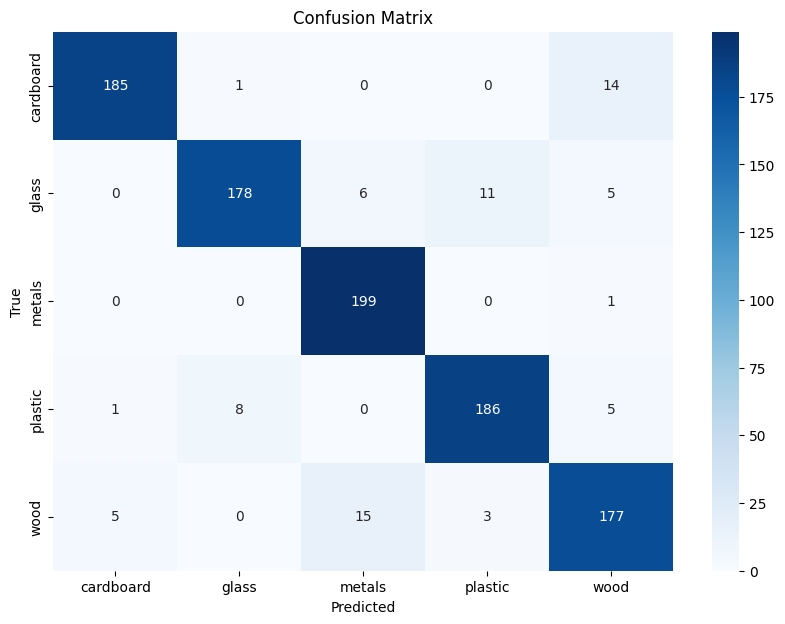

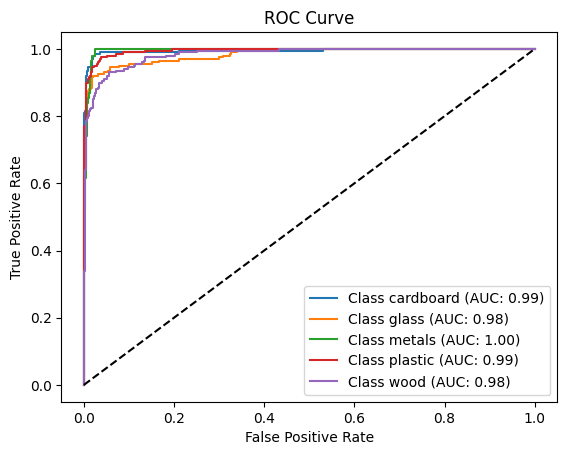

Accuracy: 0.925
Precision: 0.9262482246992793
Recall: 0.925
F1 Score: 0.9248808526947192


In [18]:
# Evaluate Xception
print("Xception Evaluation")
xception_metrics = evaluate_model(xception_model, x_test, y_test)

print("Accuracy:", xception_metrics[0])
print("Precision:", xception_metrics[1])
print("Recall:", xception_metrics[2])
print("F1 Score:", xception_metrics[3])

**# Plot Accuracy**

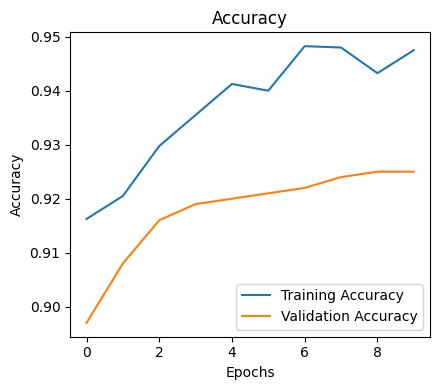

In [19]:
import matplotlib.pyplot as plt


accuracy = fine_tuning_history_xception.history['accuracy']
val_accuracy = fine_tuning_history_xception.history['val_accuracy']
precision = fine_tuning_history_xception.history['Precision']
val_precision = fine_tuning_history_xception.history['val_Precision']
recall = fine_tuning_history_xception.history['Recall']
val_recall = fine_tuning_history_xception.history['val_Recall']
loss = fine_tuning_history_xception.history['loss']
val_loss = fine_tuning_history_xception.history['val_loss']



plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()



plt.tight_layout()
plt.show()

**Plot Precision**

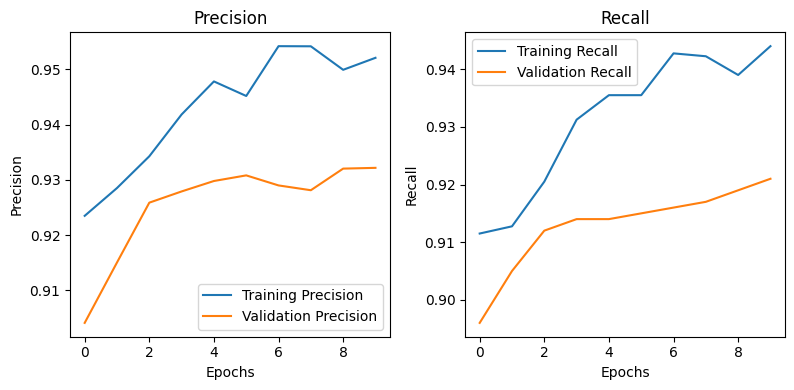

In [20]:

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()


# Plot Recall

plt.subplot(1, 3, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()



plt.tight_layout()
plt.show()

Plot Loss Curve

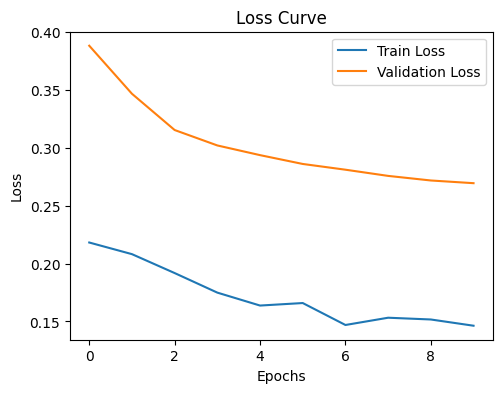

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**DenseNet Model**

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout layer to prevent overfitting
x = Dense(1024, activation='relu')(x)
output_layer = Dense(len(le.classes_), activation="softmax")(x)


densenet_model = Model(inputs=base_model.input, outputs=output_layer)

densenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

In [23]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
densenet_history = densenet_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, callbacks=[early_stopping])



Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - AUC: 0.8715 - Precision: 0.6655 - Recall: 0.5486 - accuracy: 0.6155 - loss: 1.0158 - val_AUC: 0.9758 - val_Precision: 0.8690 - val_Recall: 0.8090 - val_accuracy: 0.8460 - val_loss: 0.4457
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - AUC: 0.9590 - Precision: 0.8160 - Recall: 0.7622 - accuracy: 0.7864 - loss: 0.5592 - val_AUC: 0.9761 - val_Precision: 0.8791 - val_Recall: 0.8070 - val_accuracy: 0.8490 - val_loss: 0.4429
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - AUC: 0.9638 - Precision: 0.8179 - Recall: 0.7598 - accuracy: 0.7861 - loss: 0.5274 - val_AUC: 0.9782 - val_Precision: 0.8578 - val_Recall: 0.7960 - val_accuracy: 0.8340 - val_loss: 0.4183
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - AUC: 0.9672 - Precision: 0.8259 - Recall: 0.7705 - accuracy: 0.8052 - loss: 0.4962 - val_AUC: 0.9842 - val_Precision: 0.9068 - val_Recall: 0.8460 - val_accuracy: 0.8850 - val_loss: 0.3656
Epoch 5/10
125/125 ━━━━━━━━━

Fine Tuning

In [24]:
# Dense model fine tuning
for layer in densenet_model.layers[-10:]:
    layer.trainable = True

densenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)


fine_tuning_history = densenet_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - AUC: 0.9576 - Precision: 0.8265 - Recall: 0.7884 - accuracy: 0.8032 - loss: 0.6006 - val_AUC: 0.9890 - val_Precision: 0.9190 - val_Recall: 0.8740 - val_accuracy: 0.9060 - val_loss: 0.2942
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - AUC: 0.9715 - Precision: 0.8522 - Recall: 0.8153 - accuracy: 0.8308 - loss: 0.4753 - val_AUC: 0.9884 - val_Precision: 0.9187 - val_Recall: 0.8810 - val_accuracy: 0.9030 - val_loss: 0.2986
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - AUC: 0.9797 - Precision: 0.8642 - Recall: 0.8357 - accuracy: 0.8482 - loss: 0.3864 - val_AUC: 0.9885 - val_Precision: 0.9195 - val_Recall: 0.8800 - val_accuracy: 0.9020 - val_loss: 0.2963
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - AUC: 0.9762 - Precision: 0.8578 - Recall: 0.8263 - accuracy: 0.8389 - loss: 0.4225 - val_AUC: 0.9891 - val_Precision: 0.9212 - val_Recall: 0.8770 - val_accuracy: 0.9090 - val_loss: 0.2893
Epoch 5/10
125/125 ━━━━━━━━━

In [28]:
densenet_model.save('densenet_model.keras')

Evaluate DenseNet

DenseNet Evaluation
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step


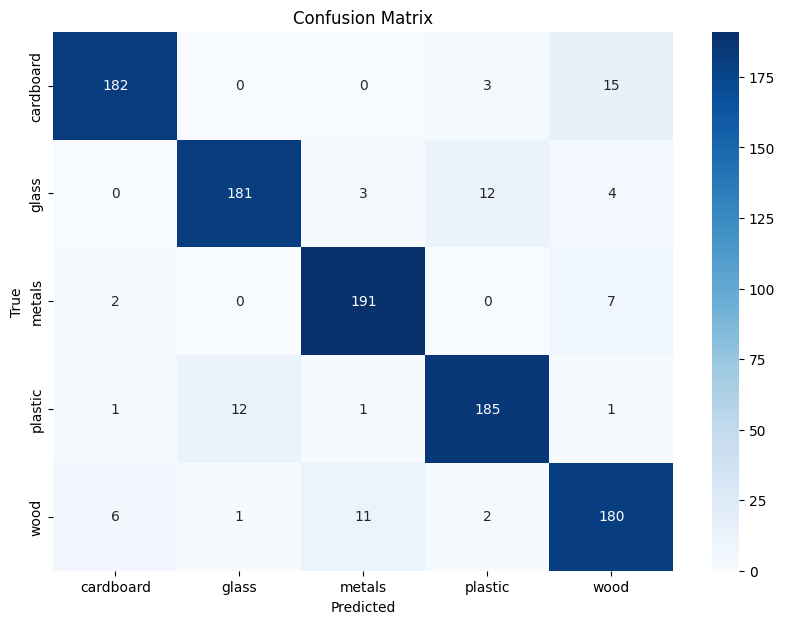

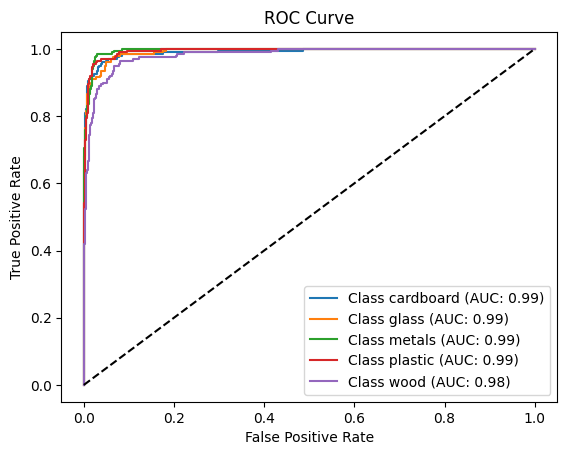

Accuracy: 0.919
Precision: 0.919692107888524
Recall: 0.919
F1 Score: 0.9191067222853899


In [25]:
print("DenseNet Evaluation")
densenet_metrics = evaluate_model(densenet_model, x_test, y_test)

print("Accuracy:", densenet_metrics[0])
print("Precision:", densenet_metrics[1])
print("Recall:", densenet_metrics[2])
print("F1 Score:", densenet_metrics[3])

plots

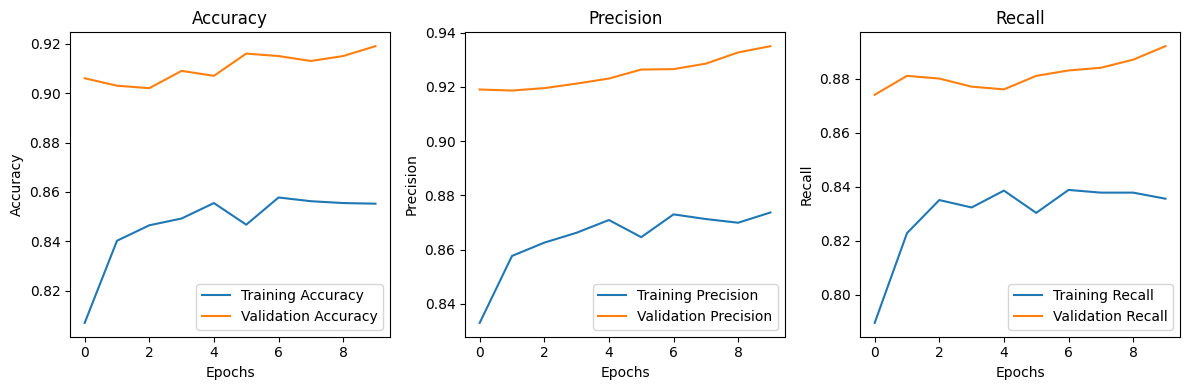

In [26]:
import matplotlib.pyplot as plt


accuracy = fine_tuning_history.history['accuracy']
val_accuracy = fine_tuning_history.history['val_accuracy']
precision = fine_tuning_history.history['Precision']
val_precision = fine_tuning_history.history['val_Precision']
recall = fine_tuning_history.history['Recall']
val_recall = fine_tuning_history.history['val_Recall']
loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision
plt.subplot(1, 3, 2)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(1, 3, 3)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()


plt.tight_layout()
plt.show()


loss curve

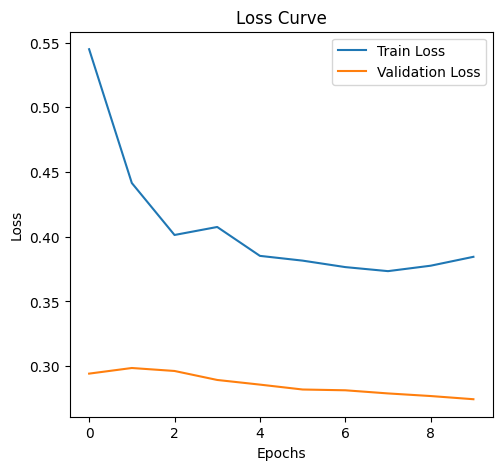

In [27]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder

# Initialize the main window
root = tk.Tk()
root.title("Image Classification GUI")
root.geometry("600x600")

# Create a canvas for scrolling
canvas = tk.Canvas(root)
canvas.pack(side="left", fill="both", expand=True)

# Add a scrollbar
scrollbar = tk.Scrollbar(root, orient="vertical", command=canvas.yview)
scrollbar.pack(side="right", fill="y")

# Configure the canvas to work with the scrollbar
canvas.configure(yscrollcommand=scrollbar.set)

# Create a frame inside the canvas for placing widgets
frame = tk.Frame(canvas)
canvas.create_window((0, 0), window=frame, anchor="nw")

# Load your models
resnet_model = load_model('resnet_model_from_scratch.keras')
xception_model = load_model('xception_model.keras')
densenet_model = load_model('densenet_model.keras')

# Label encoder and other necessary components
le = LabelEncoder()
le.fit(['cardboard', 'glass', 'metals', 'plastic', 'wood'])  # Update according to your dataset

# Function to open image and process it
def upload_image():
    global img_path, img
    img_path = filedialog.askopenfilename(title="Select an Image", filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    
    if img_path:
        img = Image.open(img_path)
        img = img.resize((256, 256))
        img_tk = ImageTk.PhotoImage(img)
        
        panel.config(image=img_tk)
        panel.image = img_tk

# Function to preprocess the image and make predictions
def preprocess_and_predict(model):
    if not img_path:
        messagebox.showwarning("No Image", "Please upload an image first.")
        return
    
    img_arr = cv2.imread(img_path)
    img_arr = cv2.resize(img_arr, (256, 256))
    img_arr = img_arr / 255.0  # Normalize the image
    
    img_arr = np.expand_dims(img_arr, axis=0)  # Add batch dimension
    prediction = model.predict(img_arr)
    
    predicted_class = le.inverse_transform([np.argmax(prediction)])
    confidence = np.max(prediction)
    
    result_label.config(text=f"Predicted: {predicted_class[0]}\nConfidence: {confidence:.2f}")

# GUI elements
model_var = tk.StringVar()
model_var.set("ResNet")  # Default model

# Create radio buttons for model selection
tk.Radiobutton(frame, text="ResNet", variable=model_var, value="ResNet").pack()
tk.Radiobutton(frame, text="Xception", variable=model_var, value="Xception").pack()
tk.Radiobutton(frame, text="DenseNet", variable=model_var, value="DenseNet").pack()

# Button to upload image
upload_button = tk.Button(frame, text="Upload Image", command=upload_image)
upload_button.pack(pady=20)

# Panel to display image
panel = tk.Label(frame)
panel.pack(pady=20)

# Button to predict
predict_button = tk.Button(frame, text="Predict", command=lambda: preprocess_and_predict(select_model()))
predict_button.pack(pady=10)

# Label to display the results
result_label = tk.Label(frame, text="Results will appear here.", font=("Helvetica", 14))
result_label.pack(pady=20)

# Function to select model based on user choice
def select_model():
    selected_model = model_var.get()
    if selected_model == "ResNet":
        return resnet_model
    elif selected_model == "Xception":
        return xception_model
    elif selected_model == "DenseNet":
        return densenet_model

# Update the scroll region to match the size of the frame
frame.update_idletasks()
canvas.config(scrollregion=canvas.bbox("all"))

# Start the GUI loop
root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
